In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time as time_calc
from time import time

from scipy.stats import randint
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.utils.fixes import loguniform
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

import joblib
import operator

In [2]:
# Read csv with 5-years of nfl play-by-play data (2020-2021)
data = pd.read_csv('nfl_post_processing_multiclass_play_classification_data.csv')
df = pd.DataFrame(data)

df.shape

(60291, 115)

In [3]:
# Convert binary columns to integers
binary_columns = df.columns[df.isin([0,1]).all()].tolist()
df[binary_columns] = df[binary_columns].apply(pd.to_numeric, downcast='integer', errors='coerce', axis=1)

df.sample(3).style

,week,posteam,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,qtr,down,goal_to_go,ydstogo,shotgun,no_huddle,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,no_score_prob,fg_prob,safety_prob,td_prob,ep,wp,drive_play_count,spread_line,total_line,div_game,surface,under_odds,over_odds,qb_rank,qb_pts,qb_plays,qb_qbr_raw,qb_qbr,qb_pass,qb_run,play_sequence_game,play_sequence_series,pass_formation,run_formation,dtg_99to95,dtg_94to90,dtg_20to11,dtg_10to06,dtg_05to01,prev1_big_play_pass,prev2_big_play_pass,prev3_big_play_pass,prev1_big_play_run,prev2_big_play_run,prev3_big_play_run,prev1_negative_pass,prev2_negative_pass,prev3_negative_pass,prev1_negative_run,prev2_negative_run,prev3_negative_run,prev1_play_off_penalty,prev1_play_def_penalty,prev2_play_off_penalty,prev2_play_def_penalty,prev3_play_off_penalty,prev3_play_def_penalty,prev1_play_run_outside,prev1_play_run_inside,prev1_play_pass_deep,prev1_play_pass_short,prev2_play_run_outside,prev2_play_run_inside,prev2_play_pass_deep,prev2_play_pass_short,prev3_play_run_outside,prev3_play_run_inside,prev3_play_pass_deep,prev3_play_pass_short,prev1_incomplete_pass,prev2_incomplete_pass,prev3_incomplete_pass,prev1_yards_gained,prev2_yards_gained,prev3_yards_gained,prev1_wpa,prev2_wpa,prev3_wpa,prev1_shotgun,prev2_shotgun,prev3_shotgun,prev1_qb_hit,prev2_qb_hit,prev3_qb_hit,prev1_no_huddle,prev2_no_huddle,prev3_no_huddle,prev1_first_down_pass,prev2_first_down_pass,prev3_first_down_pass,prev1_first_down_run,prev2_first_down_run,prev3_first_down_run,prev1_effct_play,prev2_effct_play,prev3_effct_play,remaining_downs,remaining_yards_per_down,drive_start,two_min_warning,ep_sec_ratio,posteam_rest,defteam_rest,game_start_hour,run_ratio_off_priors,run_ratio_def_priors,play_type
12586,5,CIN,75,709,709,2509,1,2,1,0,10,1,0,3,3,7,6,1,0.098468,0.207376,0.002592,0.352520,1.235542,0.665408,3,-2.000000,50.000000,0,grass,-108.000000,-104.000000,15.666667,0.100000,32.000000,53.266667,51.533333,3.933333,-0.200000,18,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3.333333,kickoff,0,0.001740,10,7,13,0.442857,0.427778,short
46764,13,NYJ,63,53,53,53,2,4,3,0,10,1,0,0,2,18,33,-15,0.781930,0.104753,0.000372,0.066130,0.534925,0.000678,8,-5.000000,44.000000,0,turf,-102.000000,-109.000000,24.333333,-4.000000,40.333333,21.233333,22.766667,0.333333,0.066667,58,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,1,0,0.000000,0.000000,14.000000,-0.000020,-0.000345,0.000180,1,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,1,10.000000,punt,1,0.009906,7,7,13,0.142857,0.000000,short
31874,9,LA,45,589,1489,1489,2,3,3,0,1,0,0,3,3,3,21,-18,0.005343,0.270425,0.004285,0.489914,3.005162,0.082566,11,7.000000,53.500000,0,turf,-111.000000,-100.000000,3.666667,4.466667,38.333333,80.733333,77.466667,7.466667,-0.233333,41,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,4.000000,0.000000,0.000000,0.001697,0.003261,-0.008257,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1.000000,punt,0,0.002017,7,7,20,0.288889,0.166667,short


## Target variable

In [4]:
# Target values - inside (middle/center/guard); outside (tackle/end/end around); deep (>10 air_yards)
target_count = df.play_type.value_counts(normalize=True)
target_count

short      0.412168
inside     0.213299
outside    0.195336
deep       0.179198
Name: play_type, dtype: float64

## Train test split and scale data
##### https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [5]:
# split data into target and feature datasets
X, y = df.loc[:, df.columns != 'play_type'], df['play_type']

# initial_features = df.drop(['play_type'], axis=1)
initial_features = X.columns.to_list()

# Create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=67)

print('Starting analysis with', X_train.shape[1], 'features')

Starting analysis with 114 features


## Baseline model for comparison
##### https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

In [6]:
# Create and fit baseline model to compare performance
baseline_model = DummyClassifier(strategy='most_frequent', random_state=67)
baseline_model.fit(X_train, y_train)

# Calculate model accuracy on test data
y_baseline_pred = baseline_model.predict(X_test)
y_baseline_balanced_accuracy_score = balanced_accuracy_score(y_test, y_baseline_pred)
y_baseline_accuracy = accuracy_score(y_test, y_baseline_pred)

print('Baseline scores:')
print(f"balanced accuracy score (test): {(round(y_baseline_balanced_accuracy_score, 3) * 100)} percent")
print(f"accuracy score (test): {(round(y_baseline_accuracy, 3) * 100)} percent")

Baseline scores:
balanced accuracy score (test): 25.0 percent
accuracy score (test): 40.6 percent


## Model pipeline 
##### https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html
##### https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
##### https://imbalanced-learn.org/stable/references/over_sampling.html

In [7]:
# Create list of features for each dtype
categorical_features = list(X_train.select_dtypes(include='object'))
ordinal_features = X_train.columns[X_train.isin([1, 2, 3, 4, 5, 6]).all()].tolist()
boolean_features = X_train.columns[X_train.isin([0, 1]).all()].tolist()

# Create list of float features
numeric_features = [x for x in X_train.columns if x not in boolean_features]
numeric_features = [x for x in numeric_features if x not in categorical_features]
numeric_features = [x for x in numeric_features if x not in ordinal_features]

print('categorical features:', len(categorical_features), ':', categorical_features)
print('ordinal features:', len(ordinal_features), ':', ordinal_features)
print('numeric features:', len(numeric_features))
print('boolean features:', len(boolean_features))
print('total features:', len(X_train.columns))

categorical features: 3 : ['posteam', 'surface', 'drive_start']
ordinal features: 4 : ['game_half', 'qtr', 'down', 'remaining_downs']
numeric features: 44
boolean features: 63
total features: 114


In [8]:
# Outlier removal
def IQR_Outliers(X, features):

    indices = [x for x in X.index]
    out_index_list = []
        
    for col in features:
        # Using nanpercentile instead of percentile because of nan values
        Q1 = np.nanpercentile(X[col], 25.)
        Q3 = np.nanpercentile(X[col], 75.)
        
        cut_off = (Q3 - Q1) * 1.5
        upper, lower = Q3 + cut_off, Q1 - cut_off
                
        outliers_index = X[col][(X[col] < lower) | (X[col] > upper)].index.tolist()
        outliers = X[col][(X[col] < lower) | (X[col] > upper)].values
        
        out_index_list.extend(outliers_index)
        
    # Use set to remove duplicates
    out_index_list = list(set(out_index_list))
    out_index_list.sort()

In [9]:
# Specify the transformations steps per category
num_transform = Pipeline(steps=[('smpl_imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                                ('iqr_outlier', IQR_Outliers(X_train, numeric_features)),
                                ('power_trans', PowerTransformer(method='yeo-johnson', copy=False)),
                                ('standard_scaler', StandardScaler()),
                               ])

cat_transform = Pipeline(steps=[('smpl_imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                                ('one_hot_encoder', OneHotEncoder(sparse=False, handle_unknown='ignore')),
                               ])

ord_transform = Pipeline(steps=[('smpl_imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                                ('ordinal_encoder', OrdinalEncoder()),
                               ])
                                
Column_Tranform = ColumnTransformer(transformers=[('numeric_trans', num_transform, numeric_features),
                                                  ('categorical_trans', cat_transform, categorical_features),
                                                  ('ordinal_trans', ord_transform, ordinal_features),
                                                  ], remainder='passthrough')

In [10]:
# Specify tree model used for feature selection
feat_model = RandomForestClassifier(n_estimators=400,
                                    class_weight='balanced_subsample',
                                    n_jobs=-1,
                                    random_state=67,
                                   )

# Create feature selection model to be imbedded in the HalvingRandomSearchCV pipeline
Feat_Select_Eval = RFE(estimator=feat_model)

In [11]:
# Specify number of target classes
n_classes = y_train.nunique()

# Specify HalvingRandomSearchCV halving parameter
halving_parameter = 2.0

# Specify the HalvingRandomSearchCV minimum/maximun resources
max_resource = 1600
resource_divisor = 2.0
min_resource = int(round((max_resource / resource_divisor), 0))

In [12]:
def random_search():
    pipeline1 = Pipeline([
    ('col', Column_Tranform),
    ('feat', Feat_Select_Eval),
    ('smpl', ADASYN(n_neighbors=n_classes, sampling_strategy='not majority', n_jobs=-1, random_state=67)),
    ('clf', RandomForestClassifier()),
    ])

    pipeline2 = Pipeline([
    ('col', Column_Tranform),
    ('feat', Feat_Select_Eval),
    ('smpl', ADASYN(n_neighbors=n_classes, sampling_strategy='not majority', n_jobs=-1, random_state=67)),
    ('clf', ExtraTreesClassifier()),
    ])
    
    pipeline3 = Pipeline([
    ('col', Column_Tranform),
    ('feat', Feat_Select_Eval),
    ('smpl', ADASYN(n_neighbors=n_classes, sampling_strategy='not majority', n_jobs=-1, random_state=67)),
    ('clf', GradientBoostingClassifier()),
    ])
 
    # RandomForestClassifier
    parameters1 = {
    'feat__n_features_to_select': loguniform(0.40, 1.00),
    'feat__step': randint(2, 15),
    'clf__criterion': ['gini'],
    'clf__max_features': ['sqrt', 'log2', None],
    'clf__max_depth': [None],
    'clf__max_samples': loguniform(0.60, 1.0),
    'clf__min_samples_split': randint(10, 70),
    'clf__min_samples_leaf': randint(10, 50),
    'clf__min_impurity_decrease': loguniform(1e-07, 1e-03),
    'clf__min_weight_fraction_leaf':  loguniform(1e-08, 1e-02),
    'clf__ccp_alpha':  loguniform(1e-05, 1e-01),
    'clf__bootstrap': [True],
    'clf__oob_score': [False],
    'clf__warm_start': [False],
    'clf__n_jobs': [6],
    'clf__random_state': [67],
    }

    # ExtraTreesClassifier
    parameters2 = {
    'feat__n_features_to_select': loguniform(0.50, 0.90),
    'feat__step': randint(2, 15),
    'clf__criterion': ['gini'],
    'clf__max_features': ['sqrt', 'log2', None],
    'clf__max_depth': [None],
    'clf__max_leaf_nodes': [None],
    'clf__max_samples': loguniform(0.60, 1.0),
    'clf__min_samples_split': randint(10, 60),
    'clf__min_samples_leaf': randint(10, 60),
    'clf__min_weight_fraction_leaf': loguniform(1e-06, 1e-02),
    'clf__min_impurity_decrease': loguniform(1e-09, 1e-05),
    'clf__ccp_alpha': loguniform(1e-06, 1e-02),
    'clf__bootstrap': [True],
    'clf__oob_score': [False],
    'clf__warm_start': [False],
    'clf__n_jobs': [6],
    'clf__random_state': [67],
    }
 
    # GradientBoostingClassifier
    parameters3 = {
    'feat__n_features_to_select': loguniform(0.80, 1.00),
    'feat__step': randint(2, 15),
    'clf__max_features': ['sqrt', 'log2', None],  
    'clf__learning_rate': loguniform(1e-04, 1e-01),
    'clf__ccp_alpha': loguniform(1e-07, 1e-03),
    'clf__max_depth': randint(5, 20),
    'clf__max_leaf_nodes': randint(10, 80),
    'clf__min_samples_split': randint(40, 120),
    'clf__min_impurity_decrease': loguniform(1e-04, 1e-01),
    'clf__min_samples_leaf': randint(10, 70),
    'clf__n_iter_no_change': [150, 175, 200, None],
    'clf__tol': loguniform(1e-09, 1e-06),
    'clf__validation_fraction': loguniform(0.10, 0.30),
    'clf__warm_start': [False],
    'clf__random_state': [67],
    }

    pars = [parameters1, parameters2, parameters3]
    pips = [pipeline1, pipeline2, pipeline3]

    result = []
    
    for i in range(len(pars)):
        
        rs = HalvingRandomSearchCV(pips[i],
                                   pars[i],
                                   factor=halving_parameter,
                                   resource='clf__n_estimators',
                                   n_candidates='exhaust',
                                   min_resources=min_resource,
                                   max_resources=max_resource,
                                   scoring='balanced_accuracy',
                                   aggressive_elimination=False,
                                   return_train_score=False,
                                   refit=True,
                                   cv=5,
                                   n_jobs=6,
                                   verbose=1,
                                   random_state=67,
                                  )

        start = time()
        
        # Fit models on training data
        rs = rs.fit(X_train, y_train)
        
        # Apply models to test data to determine model performance
        y_pred = rs.predict(X_test)
        y_pred_prob = rs.predict_proba(X_test)[:, 1]

        print("Hyperparameter search completed in %.2f minutes" % ((time() - start)/ 60))
        print(' ')
        
        # storing model results
        result.append({
        'grid': rs,
        'cv results': rs.cv_results_,
        'train score': rs.best_score_,
        'best params': rs.best_params_, 
        'best estimator': rs.best_estimator_,
        'feature importances': rs.best_estimator_.named_steps['clf'].feature_importances_,
        'selected feature count': rs.best_estimator_.named_steps['feat'].n_features_,
        'selected features alt': rs.best_estimator_.named_steps['feat'].get_feature_names_out(),
        'selected features': rs.best_estimator_.named_steps['feat'].support_,
        'test balanced accuracy score': balanced_accuracy_score(y_test, y_pred),
        'test accuracy score': accuracy_score(y_test, y_pred),
        'test weighted f1 score': f1_score(y_test, y_pred, average='weighted'),
        'test classification report': classification_report(y_test, 
                                                            y_pred, 
                                                            target_names=['short','deep','inside','outside']),
        'cv': rs.cv,
        'model #': i + 1
        })  

    # sorting results by best test score
    result = sorted(result, key=operator.itemgetter('test balanced accuracy score'), reverse=True)
    
    print(' ')
    
    for element in result:
        if element['model #']==1:
            print('RandomForest classifier: ')
        elif element['model #']==2:
            print('ExtraTrees classifier: ')
        elif element['model #']==3:
            print('GradientBoosting classifier: ')
        else:
            print('Other: ')
            
        print('Parameters:         ' + str(element['best params']))
        print(' ')
        print('Candidate features:', initial_features)
        print('')
        print(str(element['selected feature count']) + ' features selected during evaluation')
        print('Features:  ' + str(element['selected features alt']))
        print(' ')
        print('Train balanced accuracy score: ' + str(element['train score']))
        print('Test balanced accuracy score:  ' + str(element['test balanced accuracy score']))
        print('Test accuracy score:           ' + str(element['test accuracy score']))
        print('Test weighted f1 score:        ' + str(element['test weighted f1 score']))
        print(' ')
        print(str(element['test classification report']))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
        plt.show()
        
        # Print most significant features per model
        f_list = []
        total_importance = 0
        included_feats = []
        
        for f in zip(initial_features,
                     rs.best_estimator_.named_steps['feat'].get_feature_names_out(),
                     rs.best_estimator_.named_steps['clf'].feature_importances_):
            f_list.append(f)
            total_importance += f[2]

        for f in zip(initial_features,
                     rs.best_estimator_.named_steps['feat'].get_feature_names_out(),
                     rs.best_estimator_.named_steps['clf'].feature_importances_):
            if f[2] > .01:
                included_feats.append(f[0])
        
        print('\n',"Cumulative Importance =", total_importance)
        
        df2 = pd.DataFrame(f_list, columns =['feature','index','importance']).sort_values(by='importance', 
                                                                                  ascending=False)
        df2['cum_sum'] = df2['importance'].cumsum()
        print(df2.head(40))
        print(' ')
        print(' ')

    # Save best model as pickle file
    joblib.dump(rs.best_params_, 'multiclass_play_classifier_results.pkl', compress = 1)

In [13]:
# Define start time of this stage in the process
start = time_calc.time()

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 800
max_resources_: 1600
aggressive_elimination: False
factor: 2.0
----------
iter: 0
n_candidates: 2
n_resources: 800
Fitting 5 folds for each of 2 candidates, totalling 10 fits
----------
iter: 1
n_candidates: 1
n_resources: 1600
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Hyperparameter search completed in 95.02 minutes
 
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 800
max_resources_: 1600
aggressive_elimination: False
factor: 2.0
----------
iter: 0
n_candidates: 2
n_resources: 800
Fitting 5 folds for each of 2 candidates, totalling 10 fits
----------
iter: 1
n_candidates: 1
n_resources: 1600
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Hyperparameter search completed in 57.30 minutes
 
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 800
max_resources_: 1600
aggressive_elimination: False
factor: 2.0
---

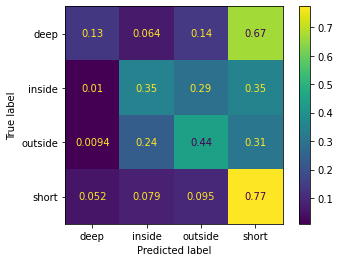


 Cumulative Importance = 0.8437127326484749
                        feature index  importance   cum_sum
88                prev3_shotgun   x88    0.138361  0.138361
37                       qb_run   x37    0.055056  0.193416
5        game_seconds_remaining    x5    0.036224  0.229640
16                defteam_score   x16    0.025877  0.255518
86                prev1_shotgun   x86    0.023483  0.279001
34                   qb_qbr_raw   x34    0.020612  0.299613
14   defteam_timeouts_remaining   x14    0.019612  0.319224
17           score_differential   x17    0.018425  0.337649
15                posteam_score   x15    0.018063  0.355712
85                    prev3_wpa   x85    0.017433  0.373145
1                       posteam    x1    0.017167  0.390312
31                      qb_rank   x31    0.015167  0.405479
110                defteam_rest  x116    0.014253  0.419732
10                      ydstogo   x10    0.013834  0.433566
3     quarter_seconds_remaining    x3    0.012072  0.44

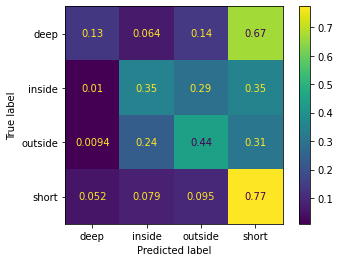


 Cumulative Importance = 0.8437127326484749
                        feature index  importance   cum_sum
88                prev3_shotgun   x88    0.138361  0.138361
37                       qb_run   x37    0.055056  0.193416
5        game_seconds_remaining    x5    0.036224  0.229640
16                defteam_score   x16    0.025877  0.255518
86                prev1_shotgun   x86    0.023483  0.279001
34                   qb_qbr_raw   x34    0.020612  0.299613
14   defteam_timeouts_remaining   x14    0.019612  0.319224
17           score_differential   x17    0.018425  0.337649
15                posteam_score   x15    0.018063  0.355712
85                    prev3_wpa   x85    0.017433  0.373145
1                       posteam    x1    0.017167  0.390312
31                      qb_rank   x31    0.015167  0.405479
110                defteam_rest  x116    0.014253  0.419732
10                      ydstogo   x10    0.013834  0.433566
3     quarter_seconds_remaining    x3    0.012072  0.44

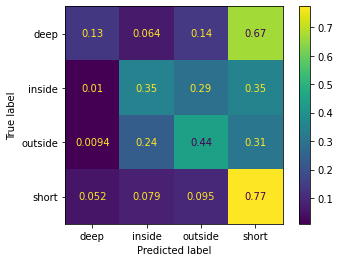


 Cumulative Importance = 0.8437127326484749
                        feature index  importance   cum_sum
88                prev3_shotgun   x88    0.138361  0.138361
37                       qb_run   x37    0.055056  0.193416
5        game_seconds_remaining    x5    0.036224  0.229640
16                defteam_score   x16    0.025877  0.255518
86                prev1_shotgun   x86    0.023483  0.279001
34                   qb_qbr_raw   x34    0.020612  0.299613
14   defteam_timeouts_remaining   x14    0.019612  0.319224
17           score_differential   x17    0.018425  0.337649
15                posteam_score   x15    0.018063  0.355712
85                    prev3_wpa   x85    0.017433  0.373145
1                       posteam    x1    0.017167  0.390312
31                      qb_rank   x31    0.015167  0.405479
110                defteam_rest  x116    0.014253  0.419732
10                      ydstogo   x10    0.013834  0.433566
3     quarter_seconds_remaining    x3    0.012072  0.44

In [14]:
%%capture --no-stdout --no-display
random_search()

In [15]:
# Define end time for process and calculate total time elapsed
end = time_calc.time()
print(round((end - start)/3600, 2), 'hours to complete hyperparameter tuning process')

5.0 hours to complete hyperparameter tuning process
